## Imports

In [1]:
import openpathsampling as paths

import openpathsampling.engines.openmm as peng_omm
from simtk.openmm import app
import simtk.openmm as mm
import simtk.unit as unit

import mdtraj as md

import numpy as np

## Setting up the engine

In [2]:
template = peng_omm.snapshot_from_pdb("../data/Alanine_solvated.pdb")

In [3]:
forcefield = app.ForceField('amber96.xml', 'tip3p.xml')

omm_topology = peng_omm.to_openmm_topology(template)

system = forcefield.createSystem(
    omm_topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers,
    constraints=app.HBonds, 
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)
hi_T_integrator = mm.LangevinIntegrator(
    500*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)
hi_T_integrator.setConstraintTolerance(0.00001)

platform = mm.Platform.getPlatformByName('OpenCL')
properties = {'OpenCLPrecision': 'mixed'}

In [4]:
engine_options = {
    'n_frames_max': 1000,
    'platform': 'OpenCL',
    'nsteps_per_frame': 10
}

In [5]:
hi_T_engine = peng_omm.Engine(
    template, 
    system, 
    hi_T_integrator, 
    properties=properties,
    options=engine_options
)
hi_T_engine.name = '500K'

In [6]:
hi_T_engine.current_snapshot = hi_T_engine.template
hi_T_engine.minimize()

## Defining states

In [7]:
# define the CVs
psi = paths.CV_MDTraj_Function("psi", md.compute_dihedrals, indices=[[6,8,14,16]])
phi = paths.CV_MDTraj_Function("phi", md.compute_dihedrals, indices=[[4,6,8,14]])

In [8]:
# define the states
deg = 180.0/np.pi
alpha = (paths.CVRangeVolumePeriodic(phi, -180/deg, 0/deg, -np.pi, np.pi) &
         paths.CVRangeVolumePeriodic(psi, 100/deg, 200/deg, -np.pi, np.pi)).named("alpha")
beta = (paths.CVRangeVolumePeriodic(phi, -180/deg, 0/deg, -np.pi, np.pi) &
         paths.CVRangeVolumePeriodic(psi, -100/deg, 0/deg, -np.pi, np.pi)).named("beta")

## Getting a first trajectory

The idea here is a little subtle, but it makes nice use of our generalized path ensemble idea.

We want a path which contains at least one frame in each state. The question is, what ensemble can we use to create such a trajectory?

The first obvious thought would be `goal_ensemble = PartInXEnsemble(stateA) & PartInXEnsemble(stateB)` (which can, of course, be further generalized to more states). However, while that *is* the ensemble we want to eventually satisfy, we can't use its `can_append` to create it, because its `can_append` always returns `True`: the trajectory will go on forever!

But we can use a trick: since what we want is the first trajectory that satisfies `goal_ensemble`, we know that every shorter trajectory will not satisfy it. This means that the shorter trajectories must satisfy the *complement* of `goal_ensemble`, and the trajectory we want will be the first trajectory that does *not* satisfy the complement!

So the trick we'll use is to build the trajectory by using the fact that the shorter trajectories are in the complement of `goal_ensemble`, which is given by `complement = AllOutXEnsemble(stateA) | AllOutXEnsemble(stateB)`. The `generate` function will stop when that is no longer true, giving us the trajectory we want. This can be directly generalized to more states.

Note that here we're not even using the `can_append` function. That happens to be the same as the ensemble itself for this particular ensemble, but conceptually, we're actually using the test of whether a trajectory is in the ensemble at all.

In [9]:
init_traj_ensemble = paths.AllOutXEnsemble(alpha) | paths.AllOutXEnsemble(beta)

In [10]:
# generate trajectory that includes frame in both states
trajectory = hi_T_engine.generate(hi_T_engine.current_snapshot, [init_traj_ensemble.can_append])

In [11]:
tmp_network = paths.TPSNetwork.from_states_all_to_all([alpha, beta])

In [12]:
subtrajectories = []
for ens in tmp_network.analysis_ensembles:
    subtrajectories += ens.split(trajectory)
print subtrajectories

[Trajectory[35]]


## Plotting the trajectory

In [13]:
# Imports for plotting
%matplotlib inline
import matplotlib.pyplot as plt

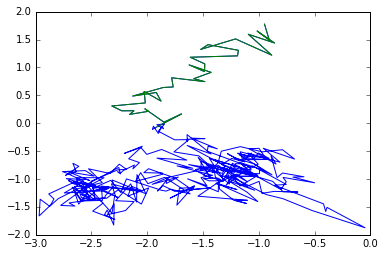

In [14]:
plt.plot(phi(trajectory), psi(trajectory))
plt.plot(phi(subtrajectories[0]), psi(subtrajectories[0]))

## Setting up another engine

In [15]:
integrator = mm.LangevinIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    1.0*unit.femtoseconds
)
integrator.setConstraintTolerance(0.00001)
engine = peng_omm.Engine(
    template, 
    system, 
    integrator, 
    properties=properties,
    options=engine_options
)
engine.name = '300K'

## Equilibrate TPS

In [16]:
network = paths.TPSNetwork(initial_states=alpha, final_states=beta)
scheme = paths.OneWayShootingMoveScheme(network, 
                                        selector=paths.UniformSelector(),
                                        engine=engine)

In [17]:
initial_conditions = scheme.initial_conditions_from_trajectories(subtrajectories)

In [18]:
scheme.assert_initial_conditions(initial_conditions)

In [19]:
sampler = paths.PathSampling(storage=paths.Storage("alanine_dipeptide_tps_equil.nc", "w", template),
                             move_scheme=scheme,
                             globalstate=initial_conditions)
sampler.live_visualization = paths.LiveVisualization(network, phi, psi, [-3.14, 3.14], [-3.14, 3.14])

In [20]:
initial_conditions[0].trajectory.is_correlated(sampler.globalstate[0].trajectory)

True

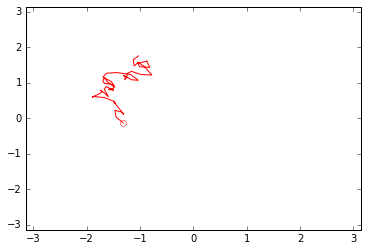

DONE! Completed 10 Monte Carlo cycles.



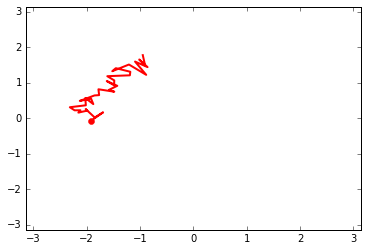

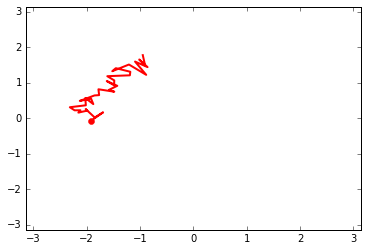

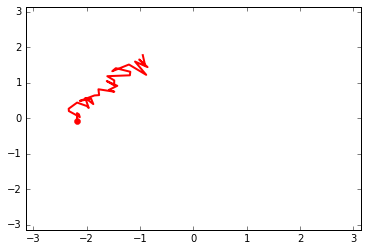

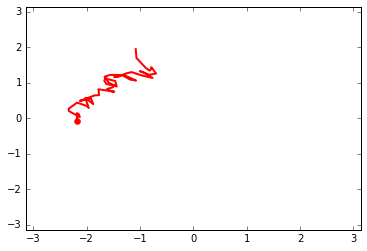

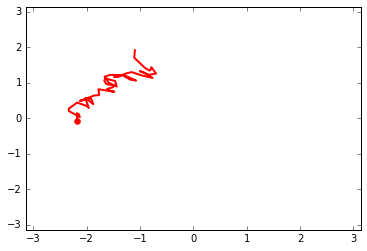

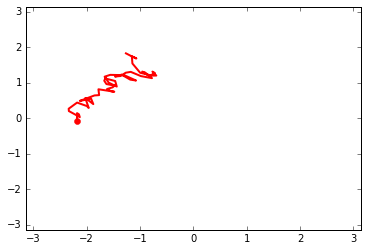

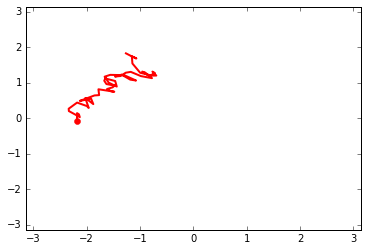

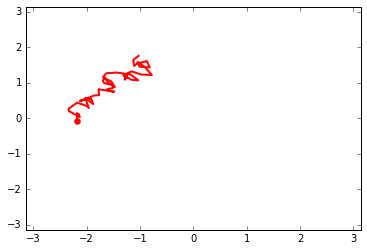

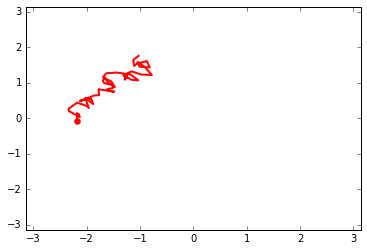

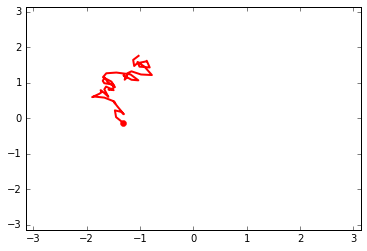

In [21]:
# this is a trick to take the first decorrelated trajectory
while (initial_conditions[0].trajectory.is_correlated(sampler.globalstate[0].trajectory)):
    sampler.run(1)